创建演示数据：

In [1]:
import numpy as np

# 坐标轴起始点
start = 0
# 坐标轴结束点
end = 6
X = np.array([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5]])
y = np.array([1598, 3898, 6220, 7799, 10510])

使用 scikit-learn 拟合：

In [2]:
from sklearn.linear_model import ElasticNet

# 初始化弹性网络回归器
reg = ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=False)
# 拟合线性模型
reg.fit(X, y)
# 权重系数
W = reg.coef_
W

array([-278.17313921, 2099.04700612])

可视化：

<IPython.core.display.Javascript object>


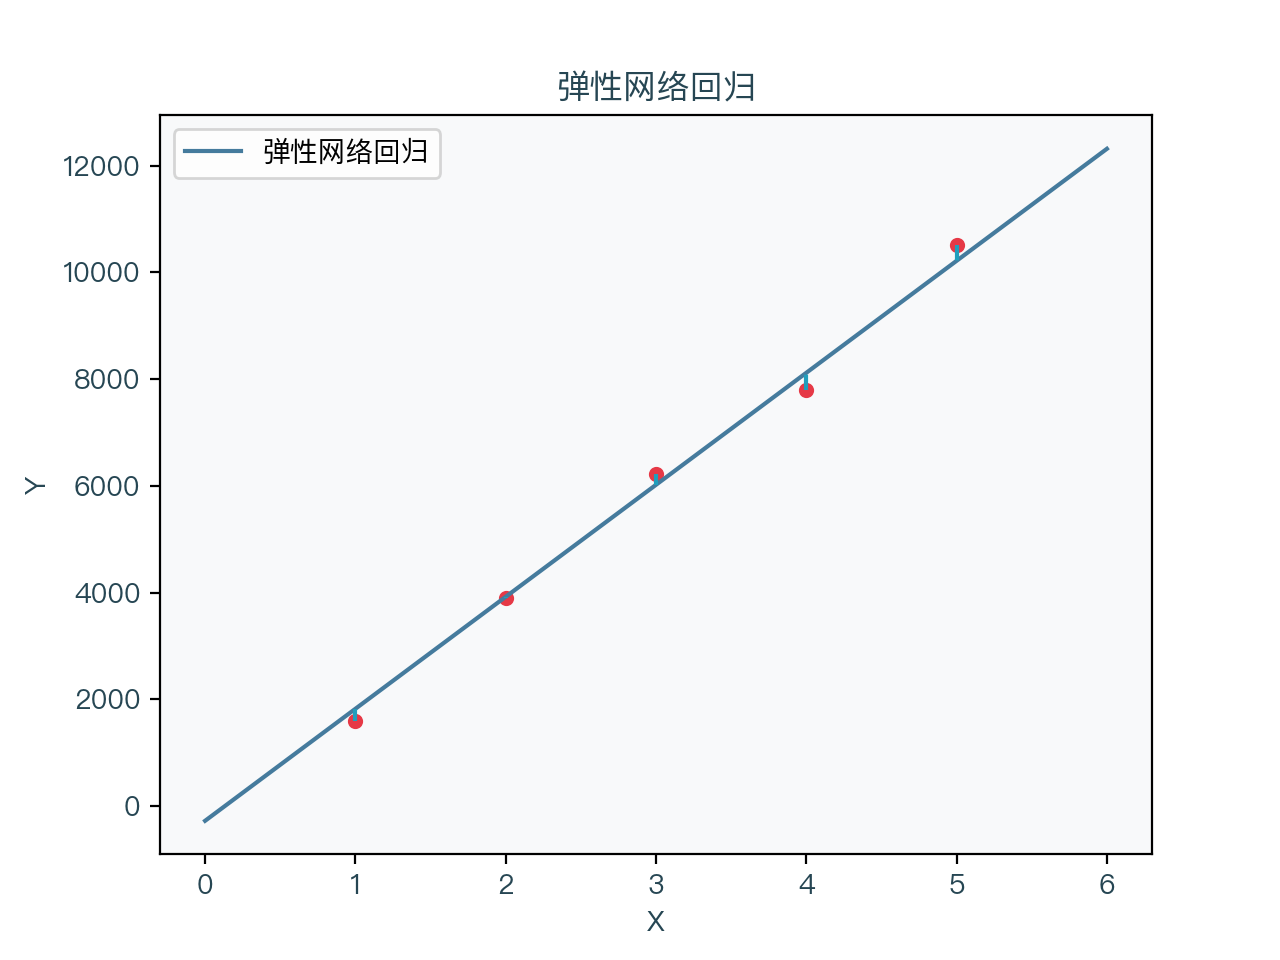

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x1 = X[:][:, 1]
y1 = y
ax.scatter(x1, y1, marker='o', s=20, c='#e63946')
x2 = np.linspace(start, end, 100)
y2 = W[1] * x2 + W[0]
ax.plot(x2, y2, '#457b9d', label='弹性网络回归')

for i in range(len(x1)):
    ax.plot(np.linspace(x1[i], x1[i], 100), np.linspace(y1[i], W[1] * x1[i] + W[0], 100), '#219ebc', linestyle='--')
ax.set_title('弹性网络回归', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend(loc="upper left")
plt.show()

使用坐标下降法实现弹性网络回归：

In [4]:
def elasticNet(X, y, lambdas=0.1, rhos=0.5, max_iter=1000, tol=1e-4):
    """
    弹性网络回归，使用坐标下降法（coordinate descent）
    args:
        X - 训练数据集
        y - 目标标签值
        lambdas - 惩罚项系数
        rhos - 混合参数，取值范围[0,1]
        max_iter - 最大迭代次数
        tol - 变化量容忍值
    return:
        W - 权重系数
    """
    # 初始化 W 为零向量
    W = np.zeros(X.shape[1])
    for it in range(max_iter):
        done = True
        # 遍历所有自变量
        for i in range(0, len(W)):
            # 记录上一轮系数
            w = W[i]
            # 求出当前条件下的最佳系数
            W[i] = down(X, y, W, i, lambdas, rhos)
            # 当其中一个系数变化量未到达其容忍值，继续循环
            if (np.abs(w - W[i]) > tol):
                done = False
        # 所有系数都变化不大时，结束循环
        if (done):
            break
    return W

def down(X, y, W, index, lambdas=0.1, rhos=0.5):
    """
    cost(W) = (x1 * w1 + x2 * w2 + ... - y)^2 / 2n + ... + λ * ρ * (|w1| + |w2| + ...) + [λ * (1 - ρ) / 2] * (w1^2 + w2^2 + ...)
    假设 w1 是变量，这时其他的值均为常数，带入上式后，其代价函数是关于 w1 的一元二次函数，可以写成下式：
    cost(w1) = (a * w1 + b)^2 / 2n + ... + λρ|w1| + [λ(1 - ρ)/2] * w1^2 + c (a,b,c,λ 均为常数)
    => 展开后
    cost(w1) = [aa / 2n + λ(1 - ρ)/2] * w1^2 + (ab / n) * w1 + λρ|w1| + c (aa,ab,c,λ 均为常数)
    """
    # 展开后的二次项的系数之和
    aa = 0
    # 展开后的一次项的系数之和
    ab = 0
    for i in range(X.shape[0]):
        # 括号内一次项的系数
        a = X[i][index]
        # 括号内常数项的系数
        b = X[i][:].dot(W) - a * W[index] - y[i]
        # 可以很容易的得到展开后的二次项的系数为括号内一次项的系数平方的和
        aa = aa + a * a
        # 可以很容易的得到展开后的一次项的系数为括号内一次项的系数乘以括号内常数项的和
        ab = ab + a * b
    # 由于是一元二次函数，当导数为零是，函数值最小值，只需要关注二次项系数、一次项系数和 λ
    return det(aa, ab, X.shape[0], lambdas, rhos)

def det(aa, ab, n, lambdas=0.1, rhos=0.5):
    """
    通过代价函数的导数求 w，当 w = 0 时，不可导
    det(w) = [aa / n + λ(1 - ρ)] * w + ab / n + λρ = 0 (w > 0)
    => w = - (ab / n + λρ) / [aa / n  + λ(1 - ρ)]
    
    det(w) = [aa / n + λ(1 - ρ)] * w + ab / n  - λρ = 0 (w < 0)
    => w = - (ab / n - λρ) / [aa / n  + λ(1 - ρ)]
    
    det(w) = NaN (w = 0)
    => w = 0
    """
    w = - (ab / n + lambdas * rhos) / (aa / n + lambdas * (1 - rhos))
    if w < 0:
        w = - (ab / n - lambdas * rhos) / (aa / n + lambdas * (1 - rhos))
        if w > 0:
            w = 0
    return w

计算权重系数：

In [5]:
W = elasticNet(X, y, lambdas=0.1, rhos=0.5)
W

array([-278.21198187, 2099.05755164])

In [6]:
import numpy as np
import sklearn.datasets

diabetes_train_splitsize = 1.0

beta_path = None
sum_abs_coeff = None

def fetch_diabetes():
    diabetes = sklearn.datasets.load_diabetes()
    X_all = diabetes.data
    y_all = diabetes.target

    total_N = len(y_all)
    train_N = int(total_N * diabetes_train_splitsize)
    test_N = total_N - train_N
    rand = np.random.mtrand.RandomState(seed=123)
    train_idx = set(rand.choice(total_N, size=(train_N,), replace=False))

    train_X = X_all[list(train_idx)]
    train_y = y_all[list(train_idx)]

    test_idx = np.zeros((test_N,), dtype=np.int32)
    test_n = 0
    for n in range(total_N):
        if n not in train_idx:
            test_idx[test_n] = n
            test_n += 1
    test_X = X_all[test_idx]
    test_y = y_all[test_idx]

    def get_add_mul(X):
        add = - np.average(X, 0)
        X1 = X + add
        mul = 1 / np.sqrt((X1 * X1).sum(0))
        return add, mul

    X_add, X_mul = get_add_mul(train_X)
    y_add = - np.average(train_y)

    train_X = (train_X + X_add) * X_mul
    train_y = train_y + y_add
    if len(test_X) > 0:
        test_X = (test_X + X_add) * X_mul
        test_y = test_y + y_add
    return train_X, train_y

In [7]:
train_X, train_y = fetch_diabetes()

elasticNet(train_X, train_y, lambdas=0.01, rhos=0.5)

array([  33.14936862,  -35.24321699,  211.02705534,  144.56065518,
         21.93051897,    0.        , -115.61926092,  100.65748468,
        185.32559078,   96.25686133])

In [8]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(alpha=0.01, l1_ratio=0.5, fit_intercept=False)
reg.fit(train_X, train_y)
reg.coef_

array([  33.14720152,  -35.24560914,  211.02392962,  144.56011492,
         21.93153316,    0.        , -115.6200168 ,  100.65883785,
        185.32633378,   96.25721354])

In [9]:
from sklearn.linear_model import ElasticNet

train_X, train_y = fetch_diabetes()

n_ratios = 100
ratios = np.linspace(0, 1, n_ratios)
n_alphas = 50
alphas = np.logspace(-3, 1, n_alphas)

coefs = []
for r in ratios:
    coef = []
    for a in alphas:
        reg = ElasticNet(alpha=a, l1_ratio=r, fit_intercept=False)
        reg.fit(train_X, train_y)
        coef.append(reg.coef_)
#         coef.append(elasticNet(train_X, train_y, lambdas=a, rhos=r))
    coefs.append(coef)

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 758354.8717697824, tolerance: 262.1009124434389
  positive)
/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776587.2876085138, tolerance: 262.1009124434389
  positive)
/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 796593.3244981075, tolerance: 262.1009124434389
  positive)
/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWar

ρ 对弹性网络回归的影响：

<IPython.core.display.Javascript object>


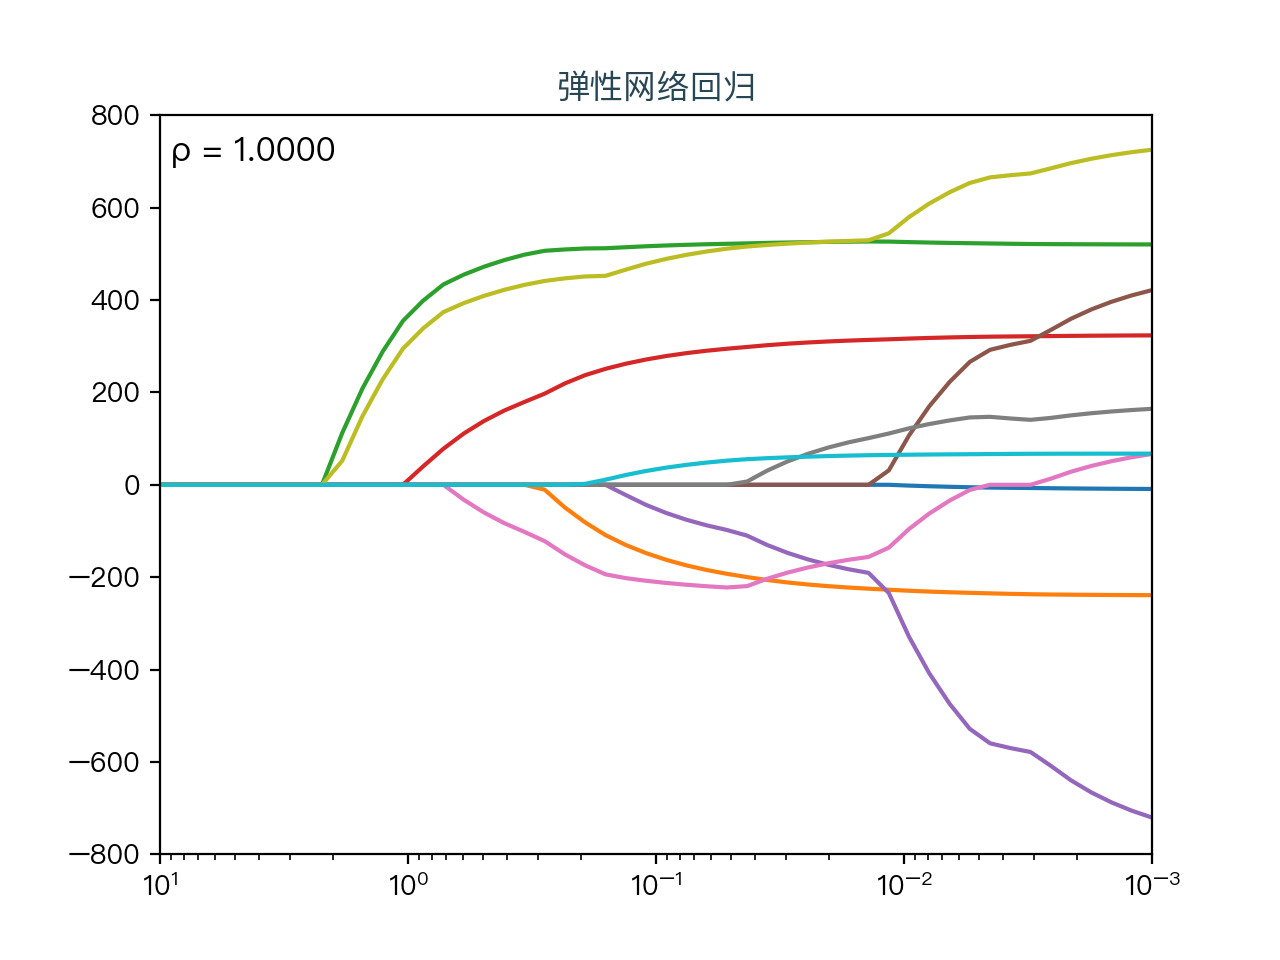

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

fig, ax = plt.subplots()
lines = []
text = plt.text(9, 700, '', fontsize=12)
coefs = np.array(coefs)
for i in range(0, 10):
    line, = ax.plot(alphas, coefs[0][:,i])
    lines.append(line)

def init():
    ax.set_xlim(alphas[0] , alphas[len(alphas) - 1])
    ax.set_ylim(-800, 800)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    return line

def update(i):
    for j in range(0, 10):
        lines[j].set_data(alphas, coefs[i][:,j])
    text.set_text("ρ = %.4f"%(ratios[i]))
    return lines

ani = animation.FuncAnimation(fig, update, frames = range(len(ratios)), init_func=init, interval=100, blit=True, repeat=False)
# ani.save('弹性网络变化.gif')
plt.title('弹性网络回归', color='#264653')
plt.axis('tight')
plt.show()

弹性网络回归与Lasso对比：

<IPython.core.display.Javascript object>


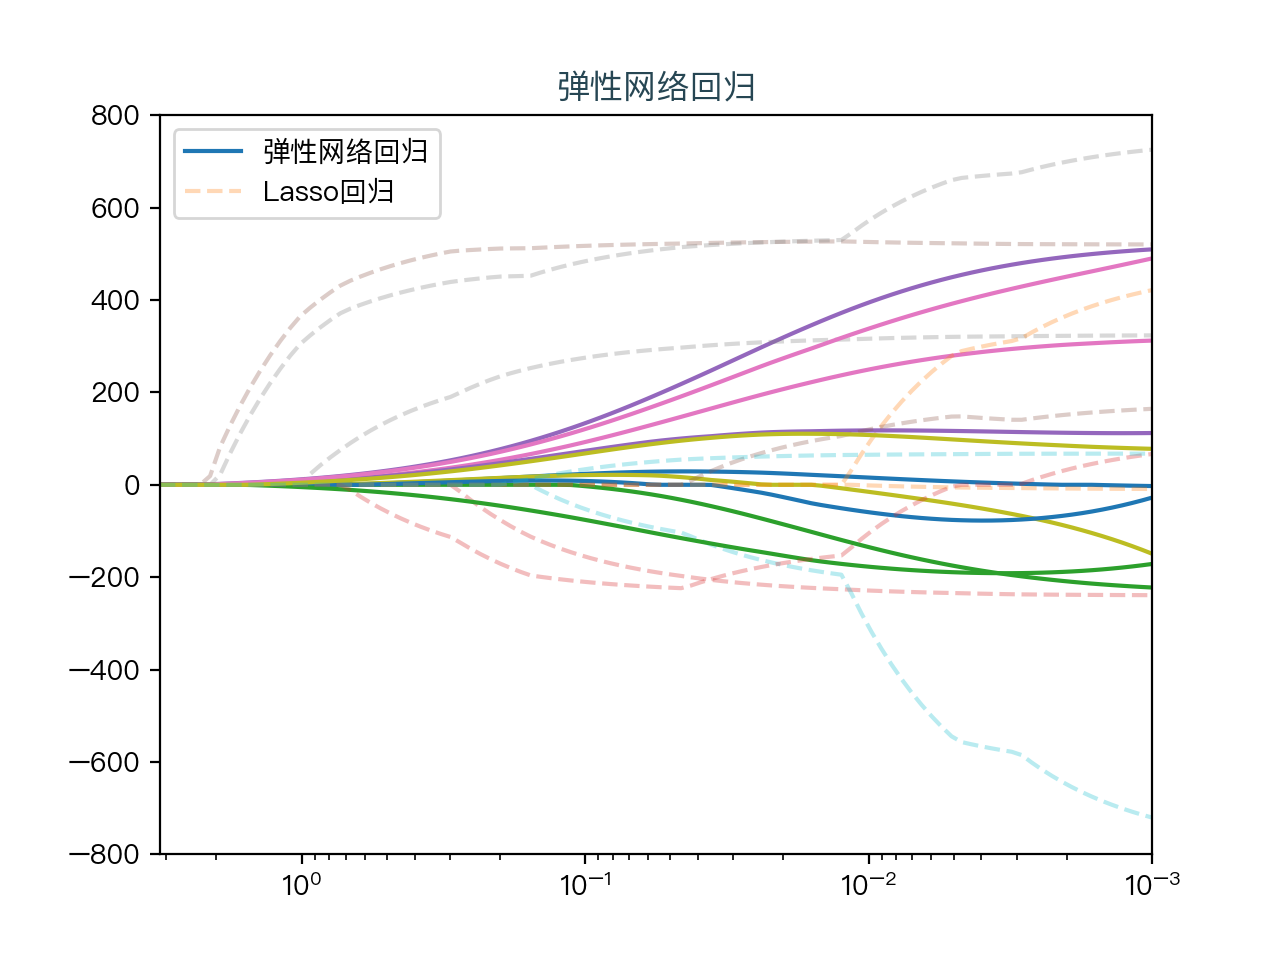

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

%matplotlib notebook

train_X, train_y = fetch_diabetes()

n_alphas = 100
alphas = np.logspace(-3, 0.5, n_alphas)

coefs = []
lasso_coefs = []
for a in alphas:
    reg = ElasticNet(alpha=a, l1_ratio=0.9, fit_intercept=False)
    reg.fit(train_X, train_y)
    coefs.append(reg.coef_)
    reg = Lasso(alpha=a, fit_intercept=False)
    reg.fit(train_X, train_y)
    lasso_coefs.append(reg.coef_)

fig, ax = plt.subplots()
xdatas, ydatas = [], []
lasso_xdatas, lasso_ydatas = [], []
lns = []
lasso_lns = []
for i in range(0, 10):
    xdatas.append([])
    ydatas.append([])
    lasso_xdatas.append([])
    lasso_ydatas.append([])
    if i == 0:
        ln, = ax.plot([], [], label='弹性网络回归')
        lasso_ln, = ax.plot([], [], linestyle='--', label='Lasso回归', alpha=0.3)
    else:
        ln, = ax.plot([], [])
        lasso_ln, = ax.plot([], [], linestyle='--', alpha=0.3)
    lns.append(ln)
    lasso_lns.append(lasso_ln)

def init():
    ax.set_xlim(alphas[0] , alphas[len(alphas) - 1])
    ax.set_ylim(-800, 800)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    return lns

def update(i):
    for j in range(0, 10):
        xdatas[j].append(alphas[i])
        ydatas[j].append(coefs[i][j])
        lns[j].set_data(xdatas[j], ydatas[j])
        lasso_xdatas[j].append(alphas[i])
        lasso_ydatas[j].append(lasso_coefs[i][j])
        lasso_lns[j].set_data(lasso_xdatas[j], lasso_ydatas[j])
    return lns, lasso_lns

ani = animation.FuncAnimation(fig, update, frames = range(len(alphas) - 1, -1, -1), init_func=init, interval=50, blit=True, repeat=False)
# ani.save('弹性网络.gif')
plt.title('弹性网络回归', color='#264653')
plt.axis('tight')
plt.legend(loc="upper left")
plt.show()